In [6]:
import warnings
from sklearn import preprocessing

import pandas as pd

import pylab as pl
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime

from sklearn import preprocessing
from sklearn import cross_validation

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [7]:
def read_training_data(data_files):
    
    age_gender = pd.read_csv(data_files['age_gender'])
    countries = pd.read_csv(data_files['countries'])
    sessions = pd.read_csv(data_files['sessions'])
    train_users = pd.read_csv(data_files['users'])
    
    return age_gender, countries, sessions, train_users

#def

In [8]:
data_files = {'age_gender':'data/age_gender_bkts.csv',
'countries':'data/countries.csv',
'sessions':'data/sessions.csv',
'users':'data/train_users_2.csv'}

In [9]:
def clean_up(dataframe):

    dataframe.replace("-unknown-", np.nan, inplace = True)
    new_timestamp = dataframe.timestamp_first_active.astype(str)
    dates = pd.to_datetime(pd.Series([datetime.strptime(date, '%Y%m%d%H%M%S') for date in new_timestamp]))
    
    av = dataframe.age.values
    dataframe['age'] = np.where(np.logical_or(av<14, av>100), -1, av)
    
    #easiness in using datetime objects
    dataframe['timestamp_first_active'] = dates
    dataframe['date_account_created'] = pd.to_datetime(dataframe.date_account_created)
    dataframe['date_first_booking'] = pd.to_datetime(dataframe.date_first_booking)
    dataframe.rename(columns = {'id':'user_id'}, inplace = True)
    df = dataframe.merge(sessions, on = 'user_id', how = 'left')
    user_ids = df['user_id']
    df_2 = df.drop('user_id', axis = 1)
    
    #sepparating in order to have numerical values for each
    
    #date_account_created
    df_2['dac_year'] = df_2.date_account_created.dt.year
    df_2['dac_month'] = df_2.date_account_created.dt.month
    df_2['dac_day'] = df_2.date_account_created.dt.day

    #timestamp_first_active
    df_2['tfa_year'] = df_2.timestamp_first_active.dt.year
    df_2['tfa_month'] = df_2.timestamp_first_active.dt.month
    df_2['tfa_day'] = df_2.timestamp_first_active.dt.day

    #date_first_booking
#     df_2['dfb_year'] = df_2.date_first_booking.dt.year
#     df_2['dfb_month'] = df_2.date_first_booking.dt.month
#     df_2['dfb_day'] = df_2.date_first_booking.dt.day
    df_2 = df_2.drop(['date_account_created','timestamp_first_active','date_first_booking'],axis = 1)
    
    
    if 'country_destination' in list(df_2.columns):

        labels = df_2.country_destination
        df_2 = df_2.drop('country_destination', axis = 1)
        
        print df_2.shape[0], user_ids.shape[0] 
        return df_2, labels, user_ids
        
    else:
        print df_2.shape[0], user_ids.shape[0] 
        return df_2, user_ids
    
    #if

#def

def encode_df(df_in,feature_list):
    
    #encoding all the non-numerical variables
    
    le = preprocessing.LabelEncoder()
    
    for item in feature_list:
        le.fit(df_in[item])
        encoded = le.transform(df_in[item])
        df_in[item] = encoded
    #for
    
    df_in = df_in.fillna(-1)
    
    return df_in

#def

def preprocessing_df(df_in,mode,normalizers=None):
    
    #
    # normalising the rest of the variables
    #
    
    if mode == 'train':
        scaler = preprocessing.MinMaxScaler().fit(df_in)
        df_in= scaler.transform(df_in)
        normalizers = scaler
        return df_in, normalizers
    elif mode == 'test':
        df_in = normalizers.transform(df_in)
        return df_in
    else:
        print 'Mode not defined {}'.format(mode)
    #if
    
#def

In [10]:
feature_list = ['gender','signup_method','language','affiliate_channel',
         'affiliate_provider','first_affiliate_tracked','affiliate_provider',
         'first_affiliate_tracked','signup_app','first_device_type','first_browser','action',
        'action_type','action_detail','device_type']

### Reading all the data
****

In [11]:
age_gender, countries, sessions, train_users = read_training_data(data_files)

### Preprocessing train data
****


In [12]:
train_set, train_labels, train_user_id = clean_up(train_users)

5677593 5677593


In [13]:
train_set = encode_df(train_set, feature_list)
train_set.shape[0]

5677593

In [14]:
train_set, normalizers = preprocessing_df(train_set,'train',normalizers=None)

In [15]:
encoded_dummies = pd.get_dummies(train_labels)
#encoded_dummies = pd.get_dummies(train_labels).as_matrix()
from sklearn import preprocessing
le = preprocessing.LabelBinarizer()
train_labels_set = le.fit_transform(train_labels)
train_labels_set


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Splitting Training Data - train and CV
****

In [25]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train_set, train_labels_set, test_size=0.3, random_state=0)

In [26]:
print "training: %i, %i" % (X_train.shape[0],y_train.shape[0])
print "test: %i, %i" % (X_test.shape[0],y_test.shape[0])

training: 3974315, 3974315
test: 1703278, 1703278


### Training phase
****

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [40]:

clf = OneVsRestClassifier(RandomForestClassifier(bootstrap = False, random_state=0))


In [ ]:

clf.fit(X_train, y_train)


In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

Feature ranking:
1. feature 1 (0.243178)
2. feature 18 (0.109364)
3. feature 21 (0.108279)
4. feature 15 (0.075855)
5. feature 20 (0.059175)
6. feature 10 (0.057522)
7. feature 17 (0.051872)
8. feature 7 (0.048249)
9. feature 0 (0.037186)
10. feature 9 (0.033832)
11. feature 5 (0.031950)
12. feature 14 (0.028515)
13. feature 11 (0.026030)
14. feature 13 (0.022100)
15. feature 2 (0.019045)
16. feature 6 (0.013437)
17. feature 12 (0.013110)
18. feature 3 (0.008842)
19. feature 4 (0.006040)
20. feature 19 (0.002337)
21. feature 16 (0.002128)
22. feature 8 (0.001955)


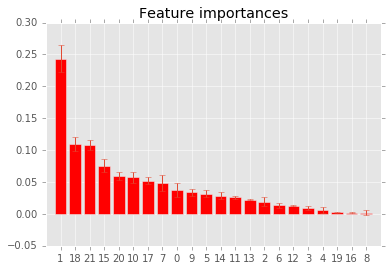

Feature ranking:
1. feature 1 (0.233455)
2. feature 18 (0.114658)
3. feature 21 (0.107537)
4. feature 15 (0.070039)
5. feature 10 (0.064660)
6. feature 0 (0.048363)
7. feature 7 (0.043591)
8. feature 14 (0.041865)
9. feature 20 (0.037590)
10. feature 17 (0.037281)
11. feature 9 (0.034532)
12. feature 5 (0.033034)
13. feature 11 (0.025774)
14. feature 13 (0.021380)
15. feature 6 (0.020058)
16. feature 2 (0.018940)
17. feature 8 (0.015938)
18. feature 12 (0.011178)
19. feature 3 (0.008920)
20. feature 4 (0.006386)
21. feature 16 (0.002520)
22. feature 19 (0.002302)


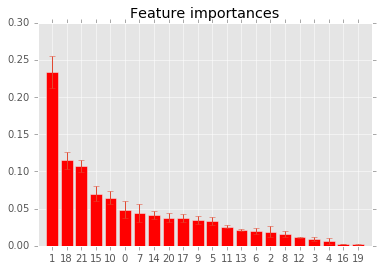

Feature ranking:
1. feature 1 (0.221587)
2. feature 21 (0.103990)
3. feature 18 (0.102884)
4. feature 15 (0.077096)
5. feature 7 (0.057854)
6. feature 10 (0.050189)
7. feature 5 (0.047167)
8. feature 20 (0.047030)
9. feature 17 (0.045764)
10. feature 0 (0.043984)
11. feature 9 (0.035388)
12. feature 2 (0.029570)
13. feature 14 (0.028592)
14. feature 11 (0.026507)
15. feature 13 (0.021521)
16. feature 6 (0.019341)
17. feature 4 (0.012823)
18. feature 12 (0.011379)
19. feature 3 (0.005905)
20. feature 8 (0.005210)
21. feature 19 (0.003507)
22. feature 16 (0.002714)


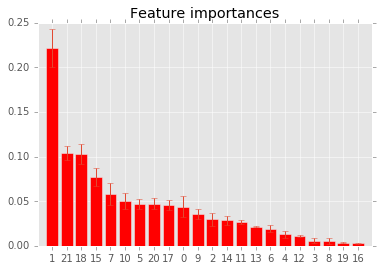

Feature ranking:
1. feature 1 (0.184439)
2. feature 18 (0.131654)
3. feature 21 (0.128593)
4. feature 15 (0.083499)
5. feature 10 (0.055787)
6. feature 17 (0.050891)
7. feature 20 (0.050032)
8. feature 7 (0.049572)
9. feature 5 (0.036259)
10. feature 0 (0.034076)
11. feature 14 (0.033004)
12. feature 9 (0.029214)
13. feature 11 (0.024555)
14. feature 2 (0.022702)
15. feature 13 (0.020398)
16. feature 6 (0.019003)
17. feature 4 (0.013134)
18. feature 3 (0.012387)
19. feature 12 (0.011821)
20. feature 8 (0.004918)
21. feature 16 (0.002063)
22. feature 19 (0.001997)


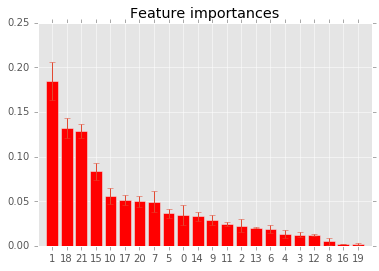

Feature ranking:
1. feature 1 (0.204358)
2. feature 18 (0.126271)
3. feature 21 (0.123852)
4. feature 15 (0.084339)
5. feature 17 (0.055900)
6. feature 10 (0.055573)
7. feature 20 (0.055002)
8. feature 5 (0.042012)
9. feature 0 (0.041154)
10. feature 7 (0.040362)
11. feature 6 (0.024822)
12. feature 11 (0.024154)
13. feature 14 (0.022214)
14. feature 13 (0.020411)
15. feature 4 (0.019672)
16. feature 9 (0.018650)
17. feature 2 (0.018126)
18. feature 12 (0.010913)
19. feature 3 (0.005965)
20. feature 16 (0.002107)
21. feature 19 (0.002090)
22. feature 8 (0.002055)


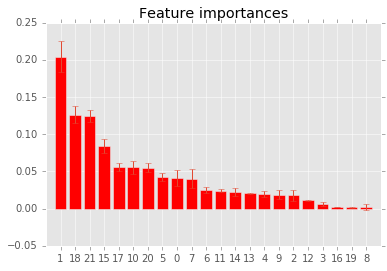

Feature ranking:
1. feature 1 (0.225513)
2. feature 21 (0.117786)
3. feature 18 (0.114826)
4. feature 15 (0.089816)
5. feature 10 (0.058589)
6. feature 17 (0.048970)
7. feature 20 (0.048614)
8. feature 0 (0.044626)
9. feature 7 (0.038273)
10. feature 5 (0.035932)
11. feature 11 (0.026717)
12. feature 14 (0.025723)
13. feature 9 (0.024977)
14. feature 6 (0.024726)
15. feature 13 (0.022369)
16. feature 2 (0.020974)
17. feature 12 (0.012052)
18. feature 3 (0.006920)
19. feature 4 (0.004820)
20. feature 8 (0.003904)
21. feature 16 (0.002072)
22. feature 19 (0.001799)


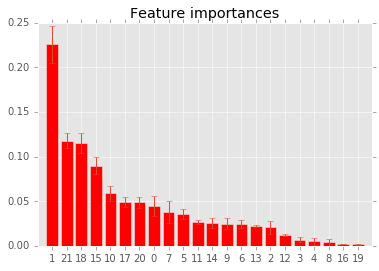

Feature ranking:
1. feature 1 (0.194013)
2. feature 21 (0.112939)
3. feature 18 (0.107845)
4. feature 15 (0.095539)
5. feature 10 (0.057970)
6. feature 17 (0.053723)
7. feature 7 (0.053677)
8. feature 20 (0.053298)
9. feature 0 (0.044522)
10. feature 5 (0.040882)
11. feature 14 (0.031736)
12. feature 9 (0.029006)
13. feature 11 (0.024017)
14. feature 6 (0.022855)
15. feature 13 (0.021514)
16. feature 4 (0.015170)
17. feature 12 (0.011527)
18. feature 2 (0.011361)
19. feature 3 (0.010625)
20. feature 8 (0.004914)
21. feature 16 (0.001469)
22. feature 19 (0.001399)


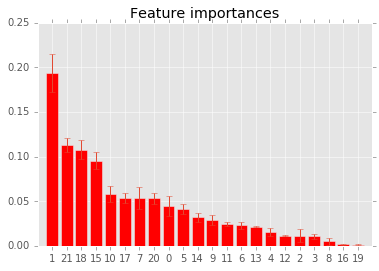

Feature ranking:
1. feature 1 (0.240503)
2. feature 21 (0.114671)
3. feature 18 (0.112855)
4. feature 15 (0.097545)
5. feature 0 (0.070854)
6. feature 10 (0.042196)
7. feature 20 (0.040426)
8. feature 17 (0.039631)
9. feature 7 (0.031331)
10. feature 11 (0.027441)
11. feature 5 (0.027394)
12. feature 14 (0.026247)
13. feature 9 (0.025178)
14. feature 13 (0.022204)
15. feature 2 (0.021982)
16. feature 3 (0.013396)
17. feature 6 (0.013330)
18. feature 4 (0.012992)
19. feature 12 (0.010890)
20. feature 8 (0.006609)
21. feature 19 (0.001195)
22. feature 16 (0.001129)


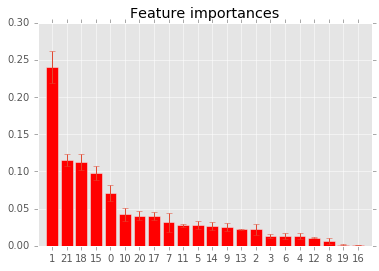

Feature ranking:
1. feature 1 (0.226796)
2. feature 18 (0.109407)
3. feature 21 (0.108165)
4. feature 15 (0.081411)
5. feature 10 (0.062349)
6. feature 0 (0.060991)
7. feature 7 (0.059207)
8. feature 17 (0.041597)
9. feature 20 (0.041186)
10. feature 5 (0.036811)
11. feature 2 (0.036749)
12. feature 11 (0.025139)
13. feature 14 (0.022685)
14. feature 13 (0.021989)
15. feature 6 (0.018045)
16. feature 9 (0.016677)
17. feature 12 (0.011906)
18. feature 4 (0.006465)
19. feature 8 (0.004337)
20. feature 3 (0.004323)
21. feature 19 (0.002078)
22. feature 16 (0.001688)


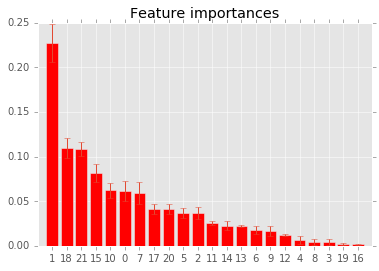

Feature ranking:
1. feature 1 (0.186546)
2. feature 21 (0.122883)
3. feature 15 (0.105122)
4. feature 18 (0.090176)
5. feature 7 (0.078269)
6. feature 10 (0.069059)
7. feature 20 (0.052133)
8. feature 17 (0.047666)
9. feature 0 (0.037847)
10. feature 9 (0.032568)
11. feature 11 (0.032361)
12. feature 5 (0.029138)
13. feature 6 (0.028474)
14. feature 13 (0.023865)
15. feature 14 (0.021555)
16. feature 12 (0.014432)
17. feature 4 (0.011668)
18. feature 2 (0.008878)
19. feature 19 (0.002750)
20. feature 3 (0.002345)
21. feature 16 (0.001610)
22. feature 8 (0.000654)


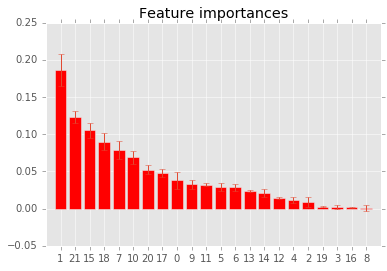

Feature ranking:
1. feature 1 (0.238468)
2. feature 21 (0.124088)
3. feature 18 (0.122790)
4. feature 15 (0.086031)
5. feature 0 (0.059525)
6. feature 17 (0.046879)
7. feature 20 (0.046239)
8. feature 10 (0.038045)
9. feature 7 (0.035331)
10. feature 5 (0.031361)
11. feature 14 (0.028093)
12. feature 9 (0.026680)
13. feature 11 (0.025020)
14. feature 13 (0.020710)
15. feature 6 (0.018579)
16. feature 2 (0.013708)
17. feature 4 (0.010401)
18. feature 12 (0.010233)
19. feature 3 (0.009205)
20. feature 8 (0.005875)
21. feature 16 (0.001405)
22. feature 19 (0.001334)


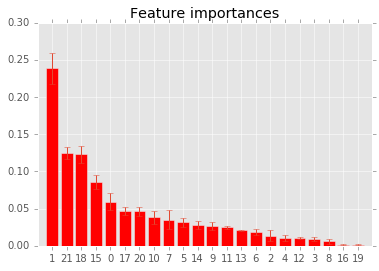

In [27]:
#plotting importances at each class
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,len(clf.estimators_)-1):
    importances = clf.estimators_[i].feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

In [ ]:
from sklearn import metrics

print metrics.f1_score(y_test, y_pred)
print metrics.accuracy_score(y_test, y_pred)

# Process Again
****

In [13]:
print train_users.shape[0], train_set.shape[0]

213451 5677593


### Reading Test Data
****

In [16]:
test_users = pd.read_csv('data/test_users.csv')
test_set, test_user_id = clean_up(test_users)


4995712 4995712


In [17]:
test_set = encode_df(test_set, feature_list)
test_set = preprocessing_df(test_set, 'test', normalizers = normalizers)
test_set.shape[0]

4995712

In [20]:
#training on the entire train set
clf = OneVsRestClassifier(RandomForestClassifier(random_state=0))
clf.fit(train_set, train_labels_set)

#predict probabilities of each country
y_pred = clf.predict_proba(test_set)

In [17]:
y_pred.shape[0]

4995712

In [39]:
last_df = pd.concat([test_user_id,pd.DataFrame(y_pred, columns = encoded_dummies.columns)], axis = 1)
last_df = last_df.groupby('user_id').mean().reset_index()

last_df.head()


,user_id,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
0,0010k6l0om,0,0,0.000000,0.000,0.000000,0.000,0.030159,0.847619,0.000000,0,0.107937,0.101587
1,0031awlkjq,0,0,0.000000,0.000,0.000000,0.025,0.062500,0.500000,0.062500,0,0.400000,0.000000
2,00378ocvlh,0,0,0.000000,0.096,0.000000,0.004,0.008000,0.478667,0.001333,0,0.324000,0.098667
3,0048rkdgb1,0,0,0.000000,0.000,0.000000,0.000,0.195652,0.840420,0.000000,0,0.178243,0.000000
4,0057snrdpu,0,0,0.178571,0.000,0.089286,0.000,0.000000,0.675000,0.000000,0,0.289286,0.007143


In [40]:
import operator

ids = []
result = {}
for index, row in last_df.iterrows():
    country_values = row[1:].to_dict()
    sorted_vals = sorted(country_values.items(), key=operator.itemgetter(1), reverse = True)[:5]
    result[row[0]]= sorted_vals

In [41]:
some_other_df = pd.DataFrame(result).T
some_other_df.head()

,0,1,2,3,4
0010k6l0om,"(NDF, 0.847619047619)","(US, 0.107936507937)","(other, 0.101587301587)","(IT, 0.0301587301587)","(FR, 0.0)"
0031awlkjq,"(NDF, 0.5)","(US, 0.4)","(NL, 0.0625)","(IT, 0.0625)","(GB, 0.025)"
00378ocvlh,"(NDF, 0.478666666667)","(US, 0.324)","(other, 0.0986666666667)","(ES, 0.096)","(IT, 0.008)"
0048rkdgb1,"(NDF, 0.840419904276)","(IT, 0.195652173913)","(US, 0.178243338008)","(FR, 0.0)","(NL, 0.0)"
0057snrdpu,"(NDF, 0.675)","(US, 0.289285714286)","(DE, 0.178571428571)","(FR, 0.0892857142857)","(other, 0.00714285714286)"


In [42]:
pd.DataFrame(some_other_df.unstack(0))\
.reset_index()\
.sort_values(['level_1','level_0'])[['level_1',0]].to_csv('something.csv', index = False)

### This returns a score of 84.53% accuracy on the website

In [22]:
len(clf.estimators_)

12

In [19]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mirunapopa/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
  File "/Users/mirunapopa/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/mirunapopa/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
  File "/Users/mirunapopa/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
    return f(*args, **kwargs)
  File "/Users/mirunapopa/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
  File "/Users/mirunapopa/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 285, in _fixed_getinnerframes
    records = fix_fr

Process PoolWorker-3:
Process PoolWorker-2:
Process PoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/mirunapopa/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/mirunapopa/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/mirunapopa/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap

KeyboardInterrupt
    self.run()
    self.run()
  File "/Users/mirunapopa/anaconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/Users/mirunapopa/anaconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/Users/mirunapopa/anaconda/lib/python2.7/multiprocessing/pool.py", line 113, in worker
  File "/Users/mirunapopa/anaconda/lib/python2.7/multiprocessing/pool.py", line 113, in worker
  

KeyboardInterrupt: 

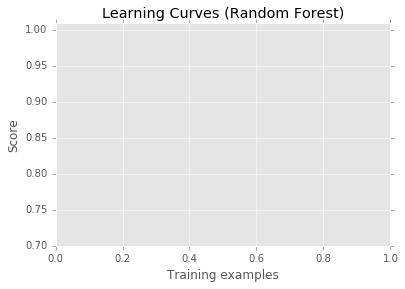

In [20]:
title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(train_set.shape[0], n_iter=100,
                                   test_size=0.3, random_state=0)

estimator = OneVsRestClassifier(RandomForestClassifier(bootstrap = False, random_state=0))
plot_learning_curve(estimator, title, train_set, train_labels_set, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


plt.show()